# Graph reconstruction in 3d 

In 3d there is no implemented filtered Back projection, hence we accomodate it 
by structuring the ECT to make the FBP easier. 
 


In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.transforms.functional as f

np.random.seed(42)

NUM_STEPS=256
NUM_PTS = 10

def generate_thetas():
    v = []
    for theta in torch.linspace(0,torch.pi,8):
        for phi in torch.linspace(0,torch.pi,64):
            v.append(
                torch.tensor([
                    torch.sin(phi)*torch.cos(theta),
                    torch.sin(phi)*torch.sin(theta),
                    torch.cos(phi)
                ])
                )
    return torch.vstack(v).T

v = generate_thetas()

In [2]:
scale = 450
def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
    ecc =  torch.nn.functional.sigmoid(scale * torch.sub(lin, nh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, nh)))
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(scale * torch.sub(lin, eh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, eh)))
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc


x = torch.tensor([
    [0,0,0.0],
    [0,-.7,0.0],
    [.5,.5,0.0],
])


# x = torch.vstack(
#     [
#        .6 * torch.sin(
#             torch.tensor(
#                 np.linspace(0, torch.pi * 2, NUM_PTS, endpoint=False),
#                 dtype=torch.float32,
#             )
#         ),
#         .3 * torch.cos(
#             torch.tensor(
#                 np.linspace(0, torch.pi * 2, NUM_PTS, endpoint=False),
#                 dtype=torch.float32,
#             )
#         ),
#         torch.zeros_like(torch.linspace(0, torch.pi * 2, NUM_PTS))
#     ]
#     ).T

x = torch.tensor(np.random.uniform(-.7,.7,size=(NUM_PTS,3)),dtype=torch.float)
from torch_geometric.utils import erdos_renyi_graph
ei = erdos_renyi_graph(NUM_PTS,.1)
# ei = torch.vstack([torch.zeros(NUM_PTS-1,dtype=torch.long),torch.arange(1,NUM_PTS,dtype=torch.long)])
# ei = torch.tensor([[0, 1, 2],
#                    [1, 2, 0]])

In [3]:
ei

tensor([[2, 4, 6, 7],
        [7, 6, 4, 2]])

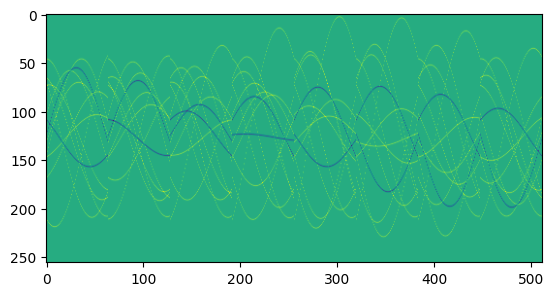

In [4]:
ect = compute_ect(x,v,ei=ei)

ect.shape
plt.imshow(ect)

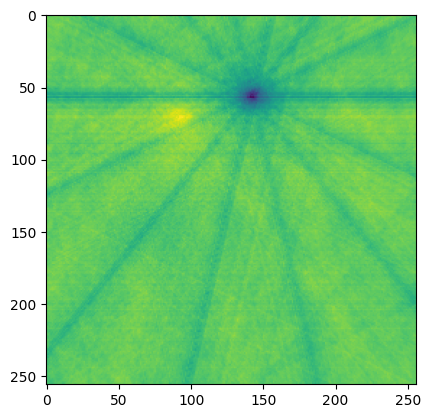

In [5]:
# ####################################################
# ### Reconstruct 3d using filtered backprojection.
# ####################################################

xg, yg ,zg = np.meshgrid(np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False), indexing='ij', sparse=True)

recon = torch.zeros(NUM_STEPS,NUM_STEPS,NUM_STEPS)

def calc_idx(theta,xg,yg,zg):
    heights = theta[0]*xg + theta[1]*yg + theta[2]*zg
    idx=((heights + 1)  * NUM_STEPS/2).long()+1
    idx[idx>NUM_STEPS-1]=NUM_STEPS-1
    return idx

i = 0
for theta,slice in zip(v.T,ect.T):
    i +=1    
    idx = calc_idx(theta,xg,yg,zg)
    reps = slice[idx]
    recon += reps
    # if i==3:
    #     recon += reps
    #     break



plt.imshow(recon[:,:,int(NUM_STEPS/2)])

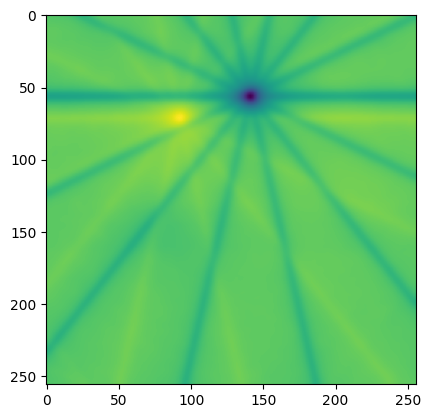

In [6]:
from scipy.ndimage import gaussian_filter

recon_f = gaussian_filter(recon,sigma=2)

plt.imshow(recon_f[:,:,128])

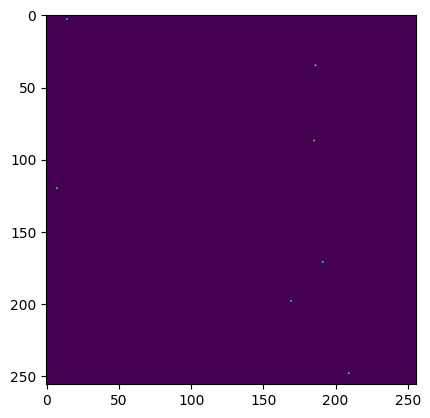

In [7]:
from scipy.ndimage import maximum_filter,minimum_filter
recon_np = recon.numpy()
res = maximum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
plt.imshow(mask[:,:,100])

In [8]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]

vals /=vals.max()

idx = np.where(vals>.5)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(pts)
print(x)



sorted(vals)

tensor([[-0.6172,  0.5000,  0.1406],
        [-0.5000, -0.3047, -0.1875],
        [-0.4453, -0.2812,  0.0391],
        [-0.1797,  0.6172,  0.3281],
        [-0.0938, -0.3047,  0.1562],
        [-0.0625,  0.3828, -0.4141],
        [ 0.0156,  0.1172, -0.6328],
        [ 0.1406, -0.4922, -0.4766],
        [ 0.2891, -0.6797,  0.6562],
        [ 0.4688, -0.4141, -0.4453]], dtype=torch.float64)
tensor([[-0.1756,  0.6310,  0.3248],
        [ 0.1381, -0.4816, -0.4816],
        [-0.6187,  0.5126,  0.1416],
        [ 0.2913, -0.6712,  0.6579],
        [ 0.4654, -0.4027, -0.4454],
        [-0.4432, -0.2741,  0.0347],
        [-0.0953, -0.2923,  0.1566],
        [-0.5047, -0.2910, -0.1871],
        [-0.0615,  0.3992, -0.4205],
        [ 0.0199,  0.1294, -0.6350]])


[tensor(0.0372),
 tensor(0.0433),
 tensor(0.0437),
 tensor(0.0441),
 tensor(0.0445),
 tensor(0.0472),
 tensor(0.0498),
 tensor(0.0503),
 tensor(0.0507),
 tensor(0.0511),
 tensor(0.0512),
 tensor(0.0533),
 tensor(0.0537),
 tensor(0.0538),
 tensor(0.0538),
 tensor(0.0540),
 tensor(0.0544),
 tensor(0.0544),
 tensor(0.0546),
 tensor(0.0547),
 tensor(0.0560),
 tensor(0.0562),
 tensor(0.0566),
 tensor(0.0566),
 tensor(0.0567),
 tensor(0.0571),
 tensor(0.0572),
 tensor(0.0577),
 tensor(0.0577),
 tensor(0.0579),
 tensor(0.0579),
 tensor(0.0580),
 tensor(0.0581),
 tensor(0.0582),
 tensor(0.0585),
 tensor(0.0585),
 tensor(0.0585),
 tensor(0.0587),
 tensor(0.0587),
 tensor(0.0589),
 tensor(0.0593),
 tensor(0.0594),
 tensor(0.0594),
 tensor(0.0595),
 tensor(0.0597),
 tensor(0.0598),
 tensor(0.0599),
 tensor(0.0599),
 tensor(0.0599),
 tensor(0.0600),
 tensor(0.0600),
 tensor(0.0601),
 tensor(0.0604),
 tensor(0.0604),
 tensor(0.0606),
 tensor(0.0606),
 tensor(0.0606),
 tensor(0.0607),
 tensor(0.0609

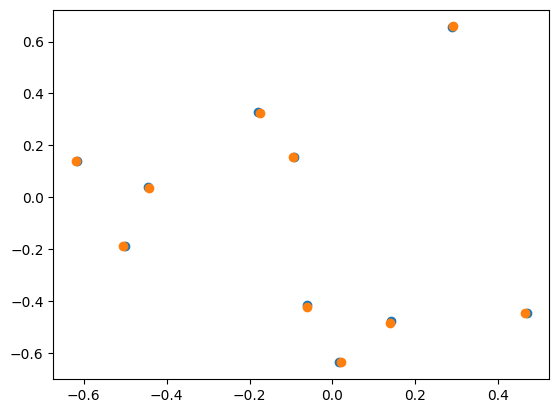

In [9]:
plt.scatter(pts[:,0],pts[:,2])
plt.scatter(x[:,0],x[:,2])




# Reconstruct Edges

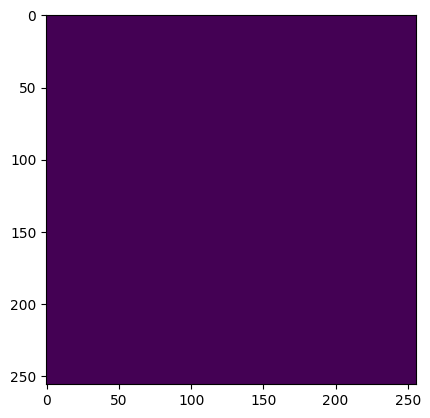

In [ ]:
res = minimum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)

In [13]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]
vals /=vals.min()
idx = np.where(vals>.8)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)

edge_pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(vals.sort()[0])

tensor([-0.0572, -0.0486, -0.0484,  ...,  0.1948,  0.9550,  1.0000])


In [14]:
ei_true = []
for ei_idx in ei.T:
    # print(ei_idx)
    ei_true.append((x[ei_idx[0]]+x[ei_idx[1]])/2)

ei_true = torch.vstack(ei_true)
print(ei_true)
print(edge_pts)

tensor([[-0.5617,  0.1108, -0.0228],
        [ 0.1851, -0.3475, -0.1444],
        [ 0.1851, -0.3475, -0.1444],
        [-0.5617,  0.1108, -0.0228]])
tensor([[-0.5547,  0.1016, -0.0234],
        [ 0.1875, -0.3594, -0.1406]], dtype=torch.float64)


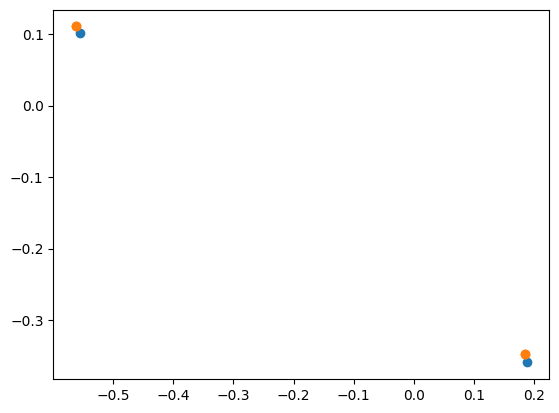

In [15]:
# plt.scatter(pts[:,0],pts[:,1])
plt.scatter(edge_pts[:,0],edge_pts[:,1])
plt.scatter(ei_true[:,0],ei_true[:,1])

In [16]:
print(ei.shape)
print(edge_pts.shape)

torch.Size([2, 4])
torch.Size([2, 3])


In [17]:
adj = np.zeros((len(pts),len(pts)))
ei_recon = []
for i in range(len(pts)):
    for j in range(len(pts)):
        pt_i = pts[i].reshape(1,3)
        pt_j = pts[j].reshape(1,3)
        pt = (pt_i+pt_j )/2
        
        for epts in edge_pts:
            if torch.norm(epts-pt) < .2:
                ei_recon.append([i,j])
        
        # pt.repeat(edge_pts.shape[0],axis=0)-edge_pts
        # print(np.linalg.norm(pt.repeat(edge_pts.shape[0],dim=0)-edge_pts,axis=1).min())
        # if np.linalg.norm(pt.repeat(edge_pts.shape[0],axis=0)-edge_pts,axis=1).min() < .1:
            # print("true")
torch.tensor(ei_recon)

tensor([[0, 1],
        [0, 2],
        [1, 0],
        [2, 0],
        [2, 9],
        [4, 7],
        [4, 9],
        [6, 8],
        [7, 4],
        [8, 6],
        [9, 2],
        [9, 4]])

In [18]:
pt = np.array([[1,1,0]])
pt2 = np.array([[1,1,1],[1,1,1],[1,1,0]])




In [35]:
lst = [[0,1],[1,0],[3,1]]
lst1 = list(set([tuple(sorted(l)) for l in lst]))
lst1
torch.tensor(lst1)

tensor([[0, 1],
        [1, 3]])